# Import the necessary libraries

In [1]:
import subprocess

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load in our dataset and clean up the data points

In [2]:
# Load in our data
df = pd.read_csv('Channel_attribution.csv')

# Grab list of columns to iterate through
cols = df.columns

# Iterate through columns to change all ints to str and remove any trailing '.0'
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [3]:
# Create a total path variable
df['Path'] = ''
for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '

In [4]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

In [5]:
# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Write DF to CSV to be executed in R
df.to_csv('Paths.csv', index=False)

# Run R code as subprocess

In [6]:
# Define the path to the R script that will run the Markov Model
path2script = './Markov.r'

# Call the R script
process = subprocess.Popen(["Rscript", "--vanilla", path2script])
process.wait()

# Load in the CSV file with the model output from R
markov = pd.read_csv('Markov - Output - Conversion values.csv')
markov['attribution'] = 'Markov'

# Select only the necessary columns and rename them
markov = markov[['channel_name', 'attribution', 'total_conversions']]
markov.columns = ['Channel', 'Attribution', 'Conversion']

# Calculate attributions for Last Touch, First Touch and Linear

In [7]:
# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()

# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()

# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()

# Merge all our 4 approaches together and evaluate the differences in outputs.

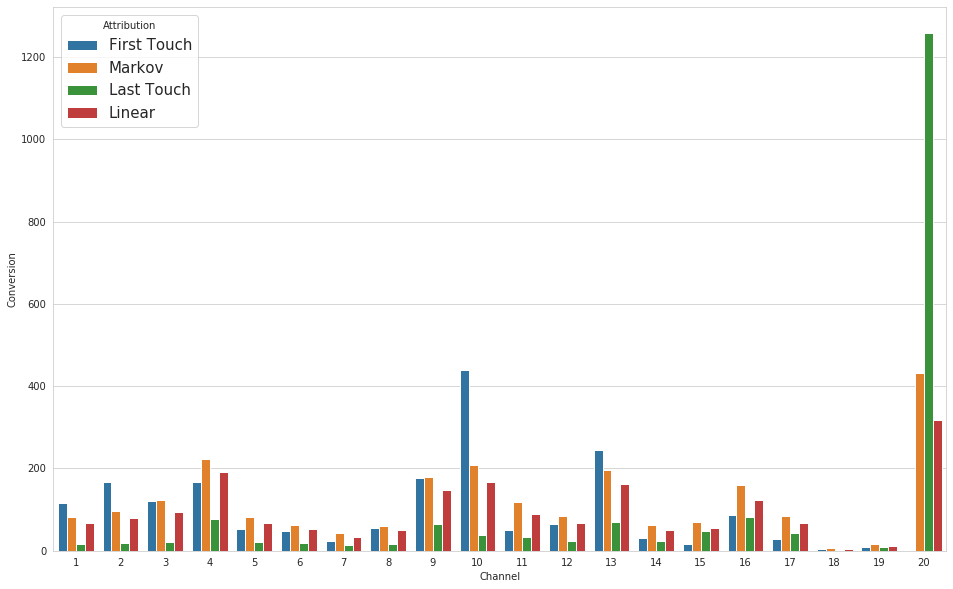

In [8]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov], sort=True)
df_total_attr['Channel'] = df_total_attr['Channel'].astype(int)
df_total_attr.sort_values(by='Channel', ascending=True, inplace=True)


# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()

# Heatmap

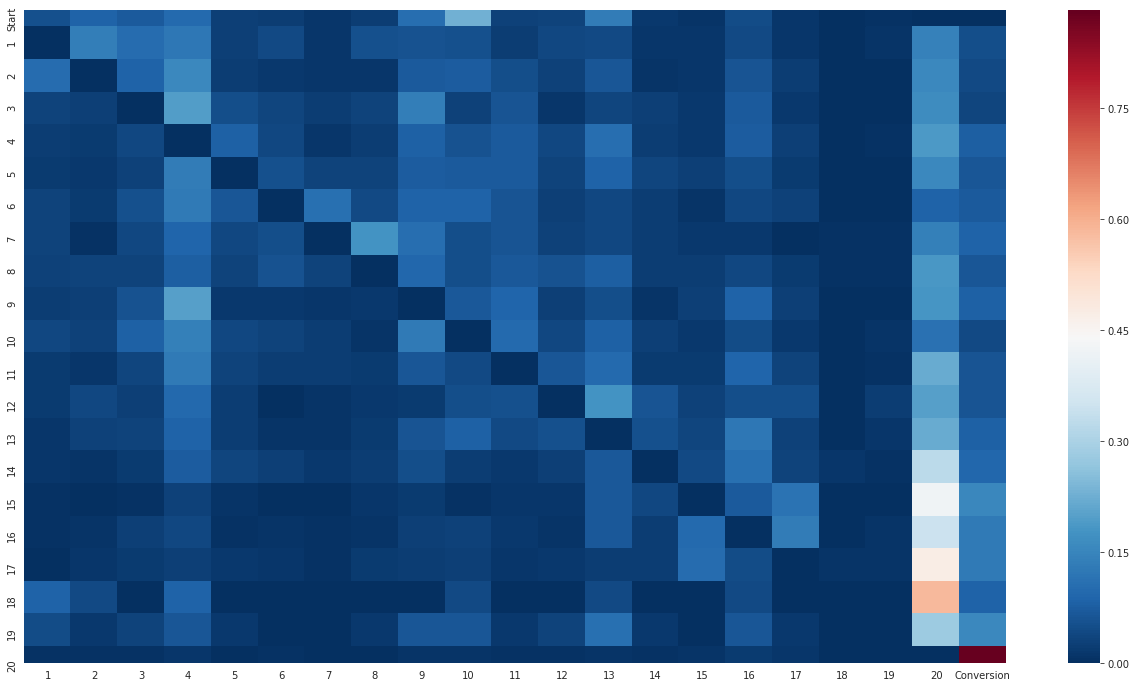

In [9]:
# Read in transition matrix CSV
trans_prob = pd.read_csv('Markov - Output - Transition matrix.csv')

# Convert data to floats
trans_prob ['transition_probability'] = trans_prob ['transition_probability'].astype(float)

# Convert start and conversion event to numeric values so we can sort and iterate through
trans_prob .replace('(start)', '0', inplace=True)
trans_prob .replace('(conversion)', '21', inplace=True)

# Get unique origin channels
channel_from_unique = trans_prob ['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)

# Get unique destination channels
channel_to_unique = trans_prob ['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

# Create new matrix with origin and destination channels as columns and index
trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = trans_prob [(trans_prob ['channel_from'] == f) & (trans_prob ['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            trans_matrix[t][f] = prob[0]
        else:
            trans_matrix[t][f] = 0

# Convert all probabilities to floats
trans_matrix = trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
trans_matrix.rename(index={'0': 'Start'}, inplace=True)
trans_matrix.rename(columns={'21': 'Conversion'}, inplace=True)

# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix, cmap="RdBu_r")
plt.show()